## Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

## Loading Data Files

In [2]:
folder_path = '../data/_test'  # dataset folder path
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
dataframes = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    file_id = os.path.splitext(file)[0]
    df = pd.read_csv(file_path, skiprows=8, header=None, usecols=range(32))
    columns_to_keep = list(range(4)) + [i for i in range(5, df.shape[1]) if i % 2 == 1]
    df = df.iloc[:, columns_to_keep]
    dataframes.append(df)

In [3]:
column_names = [
    'EMG_Time', 'Forearm2_EMG_mV',
    'ACC_Time', 'Forearm2_ACC_X_G',
    'Forearm2_ACC_Y_G',
    'Forearm2_ACC_Z_G',

    'Forearm1_EMG_mV',
    'Forearm1_ACC_X_G',
    'Forearm1_ACC_Y_G',
    'Forearm1_ACC_Z_G',

    'Biceps_EMG_mV',
    'Biceps_ACC_X_G',
    'Biceps_ACC_Y_G',
    'Biceps_ACC_Z_G',

    'Triceps_EMG_mV',
    'Triceps_ACC_X_G',
    'Triceps_ACC_Y_G',
    'Triceps_ACC_Z_G',
]

for i, df in enumerate(dataframes):
    if len(column_names) == df.shape[1]:
        df.columns = column_names
print(dataframes[0].head())

   EMG_Time  Forearm2_EMG_mV ACC_Time Forearm2_ACC_X_G Forearm2_ACC_Y_G  \
0  0.000000         0.043641        0       -0.2958984       -0.9619141   
1  0.000519         0.054887   0.0135       -0.2958984       -0.9638672   
2  0.001038         0.065461    0.027       -0.2983398       -0.9638672   
3  0.001558         0.075029   0.0405       -0.3027344       -0.9638672   
4  0.002077         0.077043    0.054       -0.3017578       -0.9628906   

  Forearm2_ACC_Z_G  Forearm1_EMG_mV Forearm1_ACC_X_G Forearm1_ACC_Y_G  \
0        0.1455078        -0.008560         0.362793       -0.9238281   
1        0.1474609        -0.010407        0.3608398       -0.9257812   
2        0.1459961        -0.012253        0.3603516       -0.9306641   
3         0.144043        -0.011582        0.3554688        -0.925293   
4         0.144043        -0.010910        0.3583984        -0.921875   

  Forearm1_ACC_Z_G  Biceps_EMG_mV Biceps_ACC_X_G Biceps_ACC_Y_G  \
0       -0.1767578      -0.006378       0.1

Data Extraction

In [4]:
Biceps_EMG_mV = dataframes[0]['Biceps_EMG_mV'].to_numpy()
EMG_Time = dataframes[0]['EMG_Time'].to_numpy()

Plot Example

In [5]:
def plot_signal(signal, title="Signal"):
    plt.plot(signal)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("mV")
    plt.grid(True)
    plt.show()

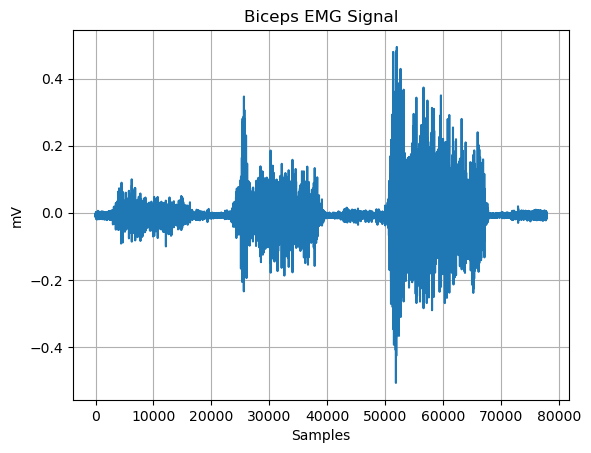

In [6]:
plot_signal(Biceps_EMG_mV, title="Biceps EMG Signal")

# EMG Signal Analysis

## 1. Bandpass Filter

In [7]:
def bandpass_filter(signal, fs, low_freq=20, high_freq=450, order=4):
    b, a = butter(order, [low_freq, high_freq], fs=fs, btype='band')
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

Frequency Estimation

In [8]:
dt = np.mean(np.diff(EMG_Time)) 
fs = 1 / dt
print(fs)

1925.9259244597833


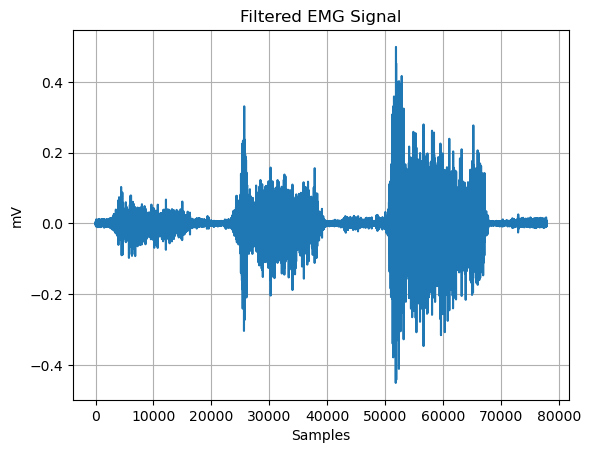

In [9]:
Filtered_EMG = bandpass_filter(Biceps_EMG_mV, fs)
plot_signal(Filtered_EMG, title="Filtered EMG Signal")

## 2. Full-wave Rectification

In [10]:
def rectification (signal):
    return np.abs(signal)

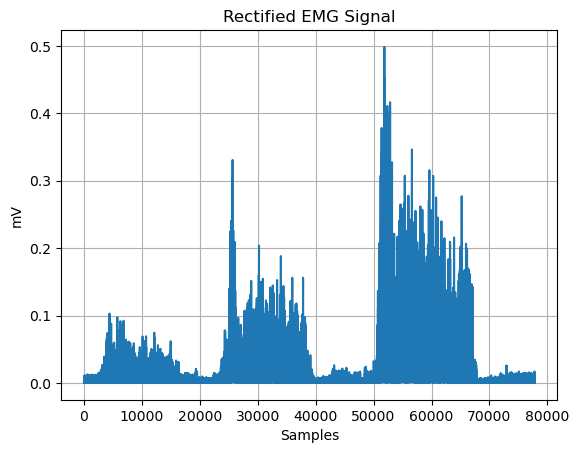

In [11]:
Rectified_EMG = rectification(Filtered_EMG)
plot_signal(Rectified_EMG, title="Rectified EMG Signal")

## 3. Smoothing

In [12]:
def RMS_moving(input_signal, fs, time_window=0.2):
    window_length = int(time_window * fs)
    rms_result = []

    for start_idx in range(0, len(input_signal) - window_length + 1, window_length):
        segment = np.array(input_signal[start_idx:start_idx + window_length])
        rms_value = np.sqrt(np.mean(segment ** 2))
        if rms_result:
            interpolated_values = np.linspace(rms_result[-1], rms_value, window_length)
        else:
            interpolated_values = np.linspace(input_signal[0], rms_value, window_length)
        rms_result.extend(interpolated_values)
        
    # Padding 
    if len(rms_result) < len(input_signal):
        padding_length = len(input_signal) - len(rms_result)
        rms_result = np.concatenate((rms_result, np.full(padding_length, rms_result[-1])))

    return rms_result

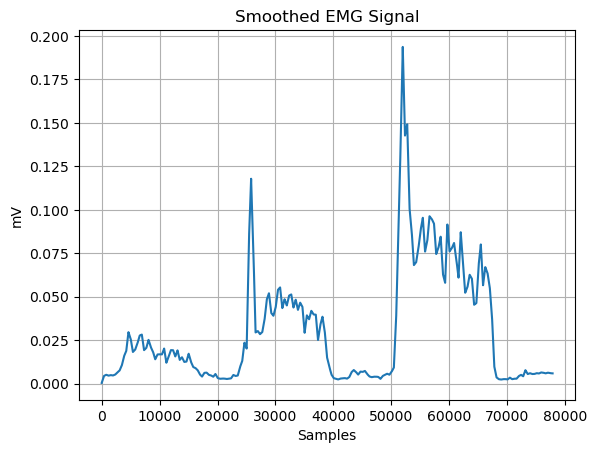

In [13]:
Smoothed_EMG = RMS_moving(Rectified_EMG, fs, 0.2)
plot_signal(Smoothed_EMG, title="Smoothed EMG Signal")

## 4. MVC Normalization

In [14]:
df = pd.read_csv('../data/_MVC/Combined_dataset.csv', index_col=0)
print(df)

               MVC
Biceps    0.451202
Forearm1  0.089273
Forearm2  0.051961
Triceps   0.175370


In [15]:
# Nome della riga da cui prendere il valore
nome_riga = 'Biceps'  # cambia con il nome reale
# Estrai il valore MVC in una variabile
mvc = df.loc[nome_riga, 'MVC']
print(mvc)

0.4512024344137171


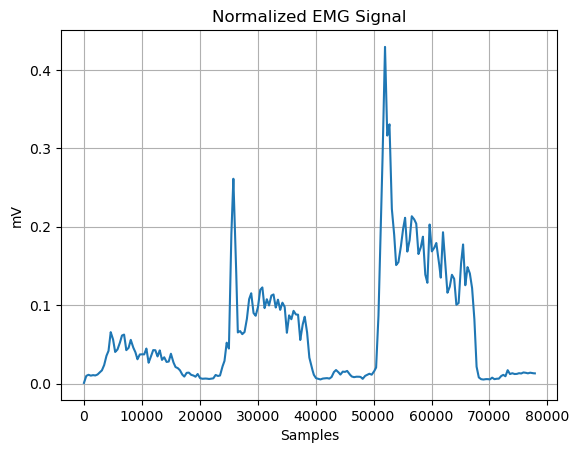

In [16]:
Normalized_EMG = Smoothed_EMG/mvc
plot_signal(Normalized_EMG, title="Normalized EMG Signal")

# Windowing and Feature Extraction

Windowing

In [17]:
window_duration = 0.2
overlap = 0.5
step_duration = window_duration * (1 - overlap)

window_size = int(window_duration * fs)
step_size = int(step_duration * fs)

In [18]:
smoothed_windows = []
filtered_windows = []
time_windows = []

for start in range(0, len(Smoothed_EMG) - window_size + 1, step_size):
    end = start + window_size
    smoothed_window = Normalized_EMG[start:end]
    filtered_window = Filtered_EMG[start:end]
    time_window = EMG_Time[start:end]
    
    smoothed_windows.append(smoothed_window)
    filtered_windows.append(filtered_window)
    time_windows.append(time_window)

Feature Extraction

In [19]:
def MAV(window):
    return np.mean(np.abs(window))

def WL(window):
    return np.sum(np.abs(np.diff(window)))

def ZC(window, threshold=1e-3):
    count = 0
    for i in range(1, len(window)):
        if (window[i-1] * window[i] < 0) and (abs(window[i] - window[i-1]) >= threshold):
            count += 1
    return count

def SSC(window, threshold=1e-3):
    count = 0
    for i in range(1, len(window)-1):
        diff1 = window[i] - window[i-1]
        diff2 = window[i] - window[i+1]
        if (diff1 * diff2 > 0) and (abs(diff1) >= threshold or abs(diff2) >= threshold):
            count += 1
    return count
    
def IEMG(window):
    return np.sum(np.abs(window))

def VAR(window):
    return np.var(window, ddof=1)  # ddof=1 per varianza campionaria

def WAMP(window, threshold=1e-3):
    count = 0
    for i in range(1, len(window)):
        if abs(window[i] - window[i-1]) >= threshold:
            count += 1
    return count

In [20]:
features = []

for smoothed_w, filtered_w in zip(smoothed_windows, filtered_windows):
    feature_dict = {
        'file_id': file_id,
        'MAV': MAV(smoothed_w),
        'WL': WL(smoothed_w),
        'IEMG': IEMG(smoothed_w),
        'VAR': VAR(smoothed_w),
        'ZC': ZC(filtered_w),
        'SSC': SSC(filtered_w),
        'WAMP': WAMP(filtered_w)
    }
    features.append(feature_dict)

In [21]:
features_df = pd.DataFrame(features)
features_df.insert(1, 'window_idx', range(len(features_df)))
print(features_df.head())

       file_id  window_idx       MAV        WL      IEMG           VAR  ZC  \
0  Trial_4_All           0  0.005376  0.008890  2.069924  6.637677e-06  25   
1  Trial_4_All           1  0.008900  0.005217  3.426460  2.566995e-06  20   
2  Trial_4_All           2  0.010594  0.001549  4.078604  2.024572e-07  23   
3  Trial_4_All           3  0.011029  0.001377  4.246344  4.293861e-08  25   
4  Trial_4_All           4  0.010777  0.001204  4.149218  1.221936e-07  24   

   SSC  WAMP  
0   34   181  
1   36   174  
2   29   191  
3   27   189  
4   40   192  


In [22]:
print(features_df.shape)

(404, 9)


# Correct Label Assignment

Indici di cambiamento: [3590, 15630, 25050, 38615, 50710, 67280, 77844]


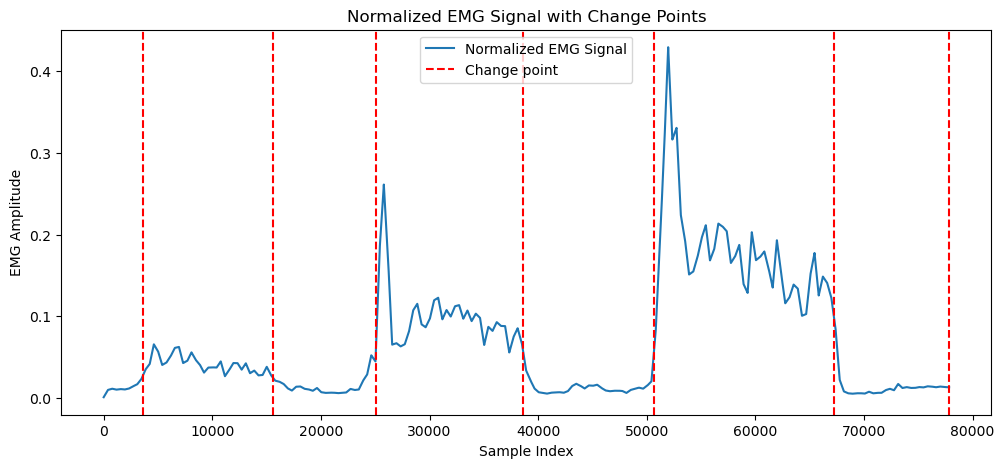

In [23]:
import ruptures as rpt

def filter_breakpoints_min_distance(bkps, min_distance=7000):
    if not bkps:
        return []
        
    filtered = [bkps[0]]
    for b in bkps[1:]:
        if b - filtered[-1] >= min_distance:
            filtered.append(b)
    return filtered

segment1 = Smoothed_EMG[:20000]
algo1 = rpt.Binseg(model="l2").fit(segment1)
bkps1 = algo1.predict(n_bkps=3)  # breakpoint relativi a segment1

# Secondo blocco: da 20000 a 40000, 2 breakpoints
segment2 = Smoothed_EMG[20000:40000]
algo2 = rpt.Binseg(model="l2").fit(segment2)
bkps2 = algo2.predict(n_bkps=3)  # breakpoint relativi a segment2
bkps2 = [b + 20000 for b in bkps2]  # aggiusto indici

# Terzo blocco: dal 40000 a fine segnale
segment3 = Smoothed_EMG[40000:]
# Qui puoi scegliere quanti breakpoints cercare, ad esempio 2
algo3 = rpt.Binseg(model="l2").fit(segment3)
bkps3 = algo3.predict(n_bkps=3)  
bkps3 = [b + 40000 for b in bkps3]

# Unisco i breakpoints escludendo i duplicati finali
# (gli ultimi breakpoint di ogni blocco sono la fine del blocco)
all_bkps = bkps1[:-1] + bkps2[:-1] + bkps3
all_bkps = filter_breakpoints_min_distance(all_bkps)

print("Indici di cambiamento:", all_bkps)

# 4. Plot segnale con linee verticali nei punti di cambiamento
plt.figure(figsize=(12, 5))
plt.plot(Normalized_EMG, label="Normalized EMG Signal")

for cp in all_bkps:
    plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == all_bkps[0] else "")

plt.title("Normalized EMG Signal with Change Points")
plt.xlabel("Sample Index")
plt.ylabel("EMG Amplitude")
plt.legend()
plt.show()

Labels Assignment

In [24]:
def assign_labels_by_indices(total_windows, start_indices, labels):
    assigned_labels = [''] * total_windows

    for i in range(len(start_indices)):
        start = start_indices[i]
        end = start_indices[i+1] if i+1 < len(start_indices) else total_windows

        for w in range(start, end):
            assigned_labels[w] = labels[i]

    return assigned_labels

In [25]:
labels = ['no weight', 'light', 'no weight', 'medium', 'no weight', 'heavy', 'no weight']
windows_start = [0] + all_bkps[:-1]
step = int(window_size * (1 - overlap))
windows_start_windows = [idx // step for idx in windows_start]
assigned_labels = assign_labels_by_indices(len(features_df), windows_start_windows, labels)
features_df['label'] = assigned_labels

In [26]:
features_df = features_df[features_df['label'] != 'discard'].reset_index(drop=True)
print(features_df.head())

       file_id  window_idx       MAV        WL      IEMG           VAR  ZC  \
0  Trial_4_All           0  0.005376  0.008890  2.069924  6.637677e-06  25   
1  Trial_4_All           1  0.008900  0.005217  3.426460  2.566995e-06  20   
2  Trial_4_All           2  0.010594  0.001549  4.078604  2.024572e-07  23   
3  Trial_4_All           3  0.011029  0.001377  4.246344  4.293861e-08  25   
4  Trial_4_All           4  0.010777  0.001204  4.149218  1.221936e-07  24   

   SSC  WAMP      label  
0   34   181  no weight  
1   36   174  no weight  
2   29   191  no weight  
3   27   189  no weight  
4   40   192  no weight  


# Features Export

In [27]:
output_folder = '../data/Extracted_features'
output_filename = f"features_{file_id}.csv"
output_path = os.path.join(output_folder, output_filename)

features_df.to_csv(output_path, index=False)